In [166]:
import tensorflow as tf
import os
from datetime import datetime
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Lambda, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import numpy as np
import cv2
import random
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K

In [190]:
def preprocess_image(image, label):
    # Define the angles tensor
    angles = tf.constant([65.0, 50.0, 75.0, 115.0, 130.0, 85.0, 105.0, 120.0, 95.0, 80.0, 110.0, 125.0, 90.0, 100.0, 60.0, 70.0, 55.0], dtype=tf.float32)

    # Calculate mirrored angles
    mirrored_angles = 180 - tf.cast(angles, tf.float32)

    image = tf.image.resize(image, [192, 192]) 
    original_image = tf.identity(image)  # Preserve the original image for comparison

    if random.random() < 0.2:
        image = tf.image.flip_left_right(image)

    def adjust_label(label):
        # Assuming label is a batch of one-hot encoded labels with shape [batch_size, num_classes]
        # Find the indices of the max value in each row (highest probability class)
        label_indices = tf.argmax(label, axis=-1)
        
        # For each label index, find the corresponding angle and then find the mirrored angle's index
        angles_batch = tf.gather(angles, label_indices)
        
        # This operation needs to be adapted to handle a batch of angles
        # Use tf.map_fn to apply the finding operation across the batch
        def find_mirrored_index(angle):
            # Find the index of this angle in the mirrored_angles list
            mirrored_index = tf.where(tf.equal(mirrored_angles, angle))
            return tf.reshape(mirrored_index, [-1])[0]

        mirrored_indices = tf.map_fn(find_mirrored_index, angles_batch, dtype=tf.int64)
        
        # Create new one-hot encoded labels based on the mirrored indices
        new_labels = tf.one_hot(mirrored_indices, depth=tf.size(angles), dtype=label.dtype)
        
        return new_labels

    # Check if flipping occurred
    is_flipped = tf.reduce_any(tf.not_equal(original_image, image))

    # Use tf.cond to conditionally adjust the label, ensuring the output matches the input type
    label = tf.cond(is_flipped, lambda: adjust_label(label), lambda: tf.identity(label))
    
    return tf.cast(image, tf.float32), label, is_flipped

In [191]:
class_names = ['65.0', '50.0', '75.0', '115.0', '130.0', '85.0', '105.0', '120.0', '95.0', '80.0', '110.0', '125.0', '90.0', '100.0', '60.0', '70.0', '55.0']

# Create TensorFlow datasets from directory
def create_datasets(directory, subset):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        class_names=['65.0', '50.0', '75.0', '115.0', '130.0', '85.0', '105.0', '120.0', '95.0', '80.0', '110.0', '125.0', '90.0', '100.0', '60.0', '70.0', '55.0'],
        color_mode='rgb',
        batch_size=300,
        image_size=(192, 256),
        shuffle=True,
        seed=123,
        validation_split=0.15,
        subset=subset)

directory = '../../data/angle_class_data'

# Load datasets
train_raw_ds = create_datasets(directory, subset="training")
val_raw_ds = create_datasets(directory, subset="validation")

class_names = train_raw_ds.class_names
print("Class names in the dataset:", class_names)

Found 13793 files belonging to 17 classes.
Using 11725 files for training.
Found 13793 files belonging to 17 classes.
Using 2068 files for validation.
Class names in the dataset: ['65.0', '50.0', '75.0', '115.0', '130.0', '85.0', '105.0', '120.0', '95.0', '80.0', '110.0', '125.0', '90.0', '100.0', '60.0', '70.0', '55.0']


In [192]:
# Take one batch from the training dataset
images, labels = next(iter(train_raw_ds))
# Assuming `images` and `labels` are your batch tensors
flipped_counts = 0
for img, lbl in zip(images, labels):
    img_batch = tf.expand_dims(img, axis=0)
    lbl_batch = tf.expand_dims(lbl, axis=0)
    
    processed_img, processed_lbl, is_flipped = preprocess_image(img_batch, lbl_batch)
    flipped_counts += tf.cast(is_flipped, tf.int32)

print("Number of flipped images in the batch:", flipped_counts.numpy())

Number of flipped images in the batch: 67


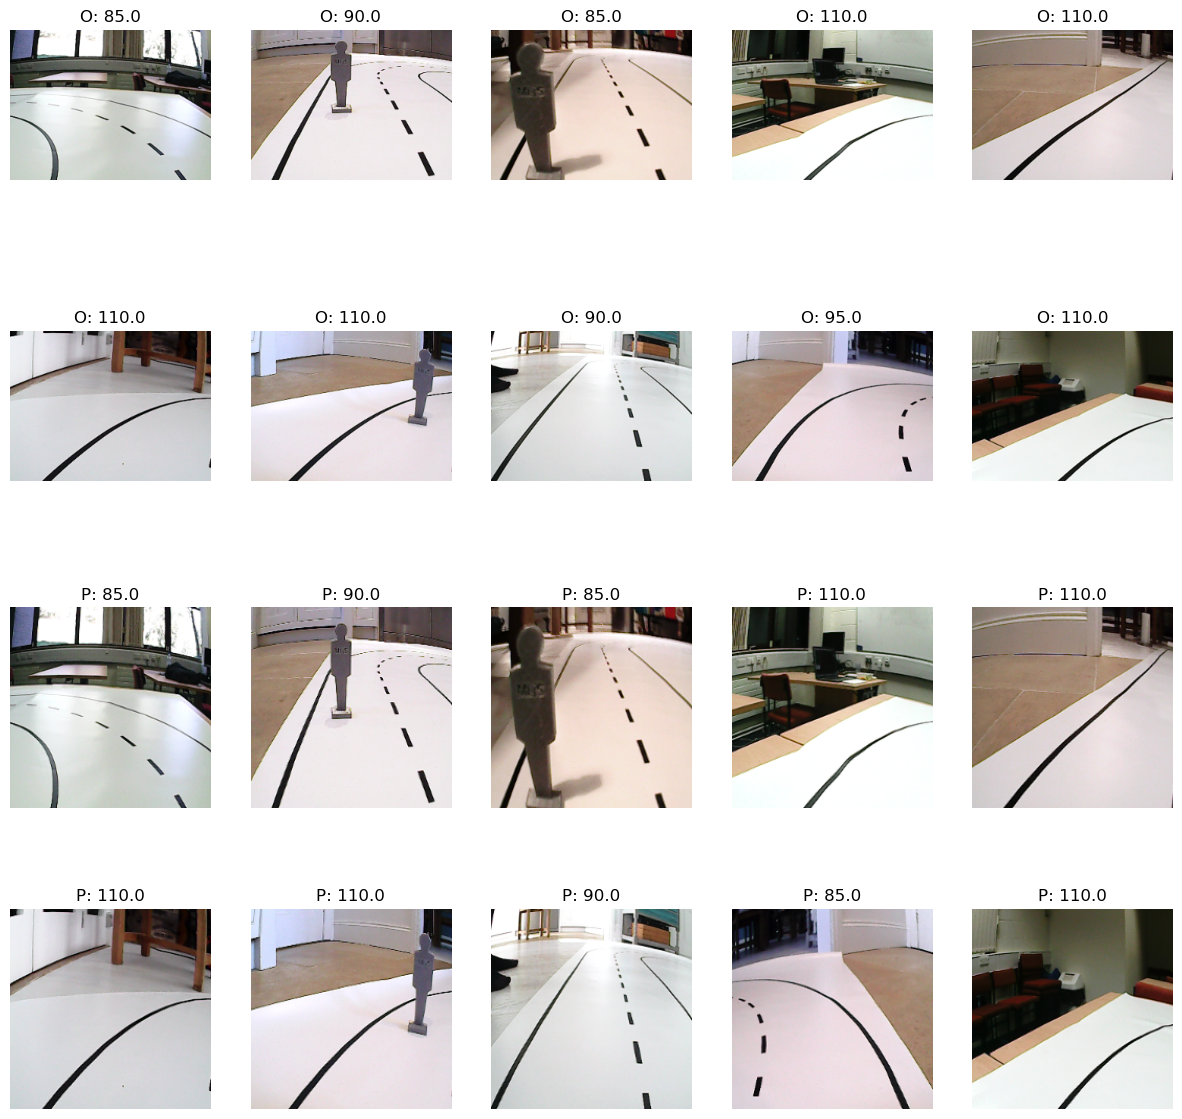

In [193]:
# Take one batch from the training dataset
images, labels = next(iter(train_raw_ds))

label_indices = tf.argmax(labels, axis=1)
label_texts = [class_names[idx] for idx in label_indices.numpy()]

# Apply preprocessing and Gaussian Blur on the batch of images
processed_images = []
p_labels = []

for img, lbl in zip(images, labels):
    # Expand dimensions to simulate a batch
    img_batch = tf.expand_dims(img, axis=0)
    lbl_batch = tf.expand_dims(lbl, axis=0)
    
    # Preprocess the image and label batch
    processed_img, processed_lbl, _ = preprocess_image(img_batch, lbl_batch)
    
    # Append the processed image to the list (remove batch dimension for visualization)
    processed_images.append(processed_img[0])
    p_label_indices = tf.argmax(processed_lbl, axis=-1)
    p_label_texts = [class_names[idx] for idx in p_label_indices.numpy()] 
    p_labels.append(p_label_texts[0])


# Plotting the images
plt.figure(figsize=(15, 15))
for i in range(min(10, len(images))):  # Assume at least 5 images in a batch
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"O: {label_texts[i]}")
    plt.axis("off")

    # Plot preprocessed image
    ax = plt.subplot(4, 5, i + 11)  # Offset by 5 to go to the next row in a 3x5 grid
    plt.imshow(processed_images[i].numpy().astype("uint8"))
    plt.title(f"P: {p_labels[i]}")
    plt.axis("off")

plt.show()


## Utils
### 1. Gaussian Blur
### 2. SpatialPyramidPooling
### Improvements: Restructing, ...

In [205]:
class RandomGaussianBlur(Layer):
    def __init__(self, kernel_size, factor, **kwargs):
        super(RandomGaussianBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.factor = factor  # Assuming factor is either a float or a tuple of floats.

    def get_random_transformation(self, img_shape):
        # Calculate random factor, ensuring numerical stability
        if isinstance(self.factor, tuple):
            factor = tf.random.uniform((), self.factor[0], self.factor[1])
        else:
            factor = self.factor

        # Prevent division by zero or near-zero factors which might lead to numerical issues
        factor = tf.maximum(factor, K.epsilon())

        # Generate the Gaussian kernels
        kernel_v = self.get_kernel(factor, self.kernel_size)
        kernel_h = tf.transpose(kernel_v)

        kernel_v = tf.reshape(kernel_v, [self.kernel_size, 1, 1, 1])
        kernel_h = tf.reshape(kernel_h, [1, self.kernel_size, 1, 1])
        return kernel_v, kernel_h

    def call(self, inputs):
        blur_v, blur_h = self.get_random_transformation(tf.shape(inputs)[-3:])
        num_channels = tf.shape(inputs)[-1]
        blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
        blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])

        # Apply the blurring kernels
        blurred = tf.nn.depthwise_conv2d(inputs, blur_h, strides=[1, 1, 1, 1], padding="SAME")
        blurred = tf.nn.depthwise_conv2d(blurred, blur_v, strides=[1, 1, 1, 1], padding="SAME")
        return blurred

    @staticmethod
    def get_kernel(factor, filter_size):
        """Generates a Gaussian kernel for use in RandomGaussianBlur."""
        range = tf.range(-filter_size // 2 + 1, filter_size // 2 + 1, dtype=tf.float32)
        gaussian_kernel = tf.exp(-0.5 * (range / factor) ** 2)
        gaussian_kernel = gaussian_kernel / tf.reduce_sum(gaussian_kernel)
        return gaussian_kernel

    def get_config(self):
        config = super(RandomGaussianBlur, self).get_config()
        config.update({
            'kernel_size': self.kernel_size,
            'factor': self.factor
        })
        return config

# Register the custom layer for loading models with this layer without specifying custom_objects
get_custom_objects().update({'RandomGaussianBlur': RandomGaussianBlur})

In [113]:
class GaussianBlurLayer(Layer):
    def __init__(self, kernel_size=(5, 5), sigma=0, **kwargs):
        super(GaussianBlurLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.sigma = sigma

    def call(self, inputs):
        # Wrap the cv2 GaussianBlur operation in tf.py_function to ensure compatibility with TensorFlow tensors
        def blur_function(image):
            if not isinstance(image, np.ndarray):
                print("Image is not a numpy array. Attempting conversion.")
            # image is a numpy array here
            blurred_image = cv2.GaussianBlur(image, self.kernel_size, self.sigma)
            return blurred_image

        # Apply the blur function on each input
        blurred_inputs = tf.map_fn(lambda img: tf.numpy_function(blur_function, [img], tf.float32), inputs, fn_output_signature=tf.float32)
        blurred_inputs.set_shape(inputs.shape)  # Ensure output shape is set correctly
        return blurred_inputs

    def get_config(self):
        config = super(GaussianBlurLayer, self).get_config()
        config.update({
            'kernel_size': self.kernel_size,
            'sigma': self.sigma,
        })
        return config

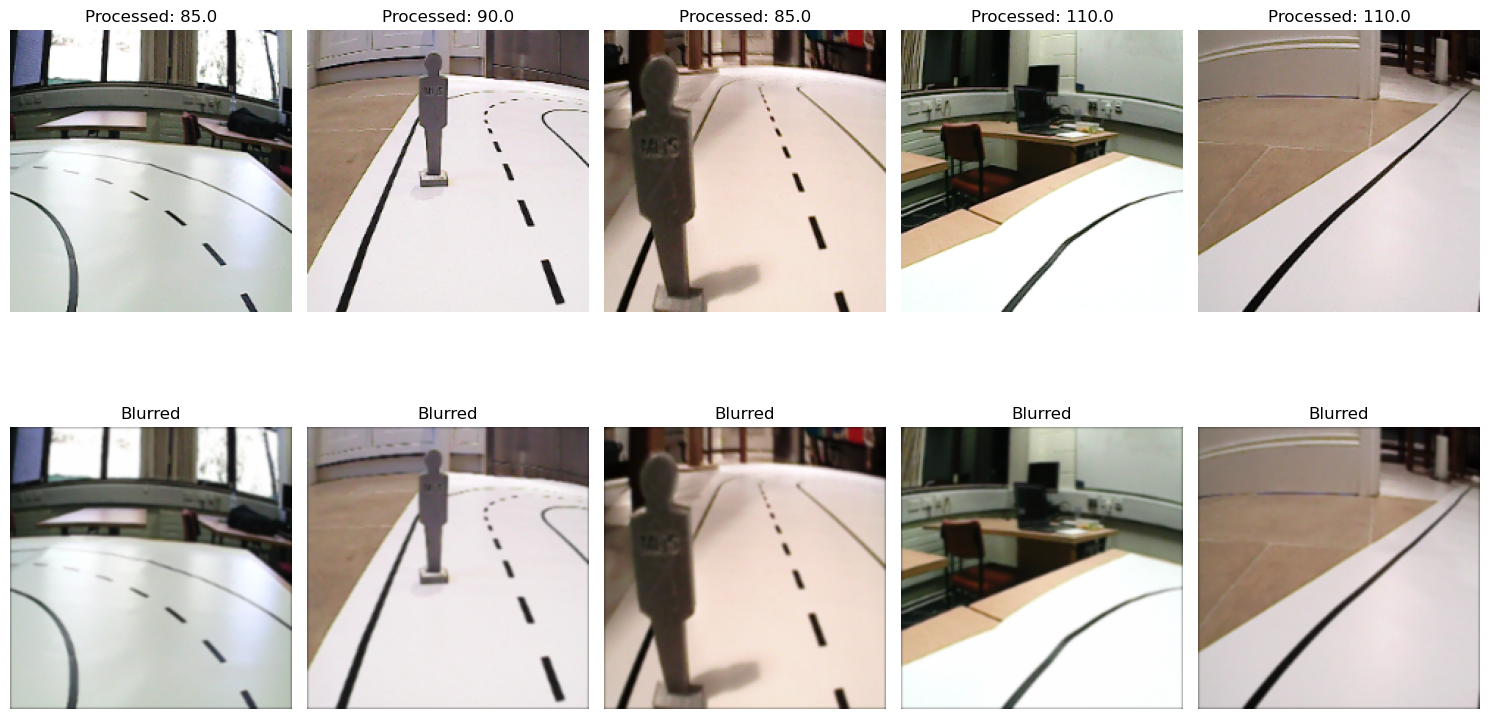

In [206]:
processed_images_tensor = tf.stack(processed_images)

# Initialize and apply Gaussian blur layer
# gaussian_blur_layer = GaussianBlurLayer(kernel_size=(3, 3), sigma=0)
gaussian_blur_layer = RandomGaussianBlur(5,0.8)
blurred_images = gaussian_blur_layer(processed_images_tensor)

# Plotting the original, processed, and blurred images
plt.figure(figsize=(15, 20))
for i in range(min(5, len(images))):  # Adjust range if necessary
    # Plot processed image
    ax = plt.subplot(5, 5, i + 1)  # Offset by 5 to go to the next row
    plt.imshow(processed_images[i].numpy().astype("uint8"))
    plt.title(f"Processed: {p_labels[i]}")
    plt.axis("off")

    # Plot Gaussian blurred image
    ax = plt.subplot(5, 5, i + 6)  # Offset by another 5 to go to the next row
    plt.imshow(blurred_images[i].numpy().astype("uint8")
    plt.title(f"Blurred")
    plt.axis("off")

plt.tight_layout()
plt.show()

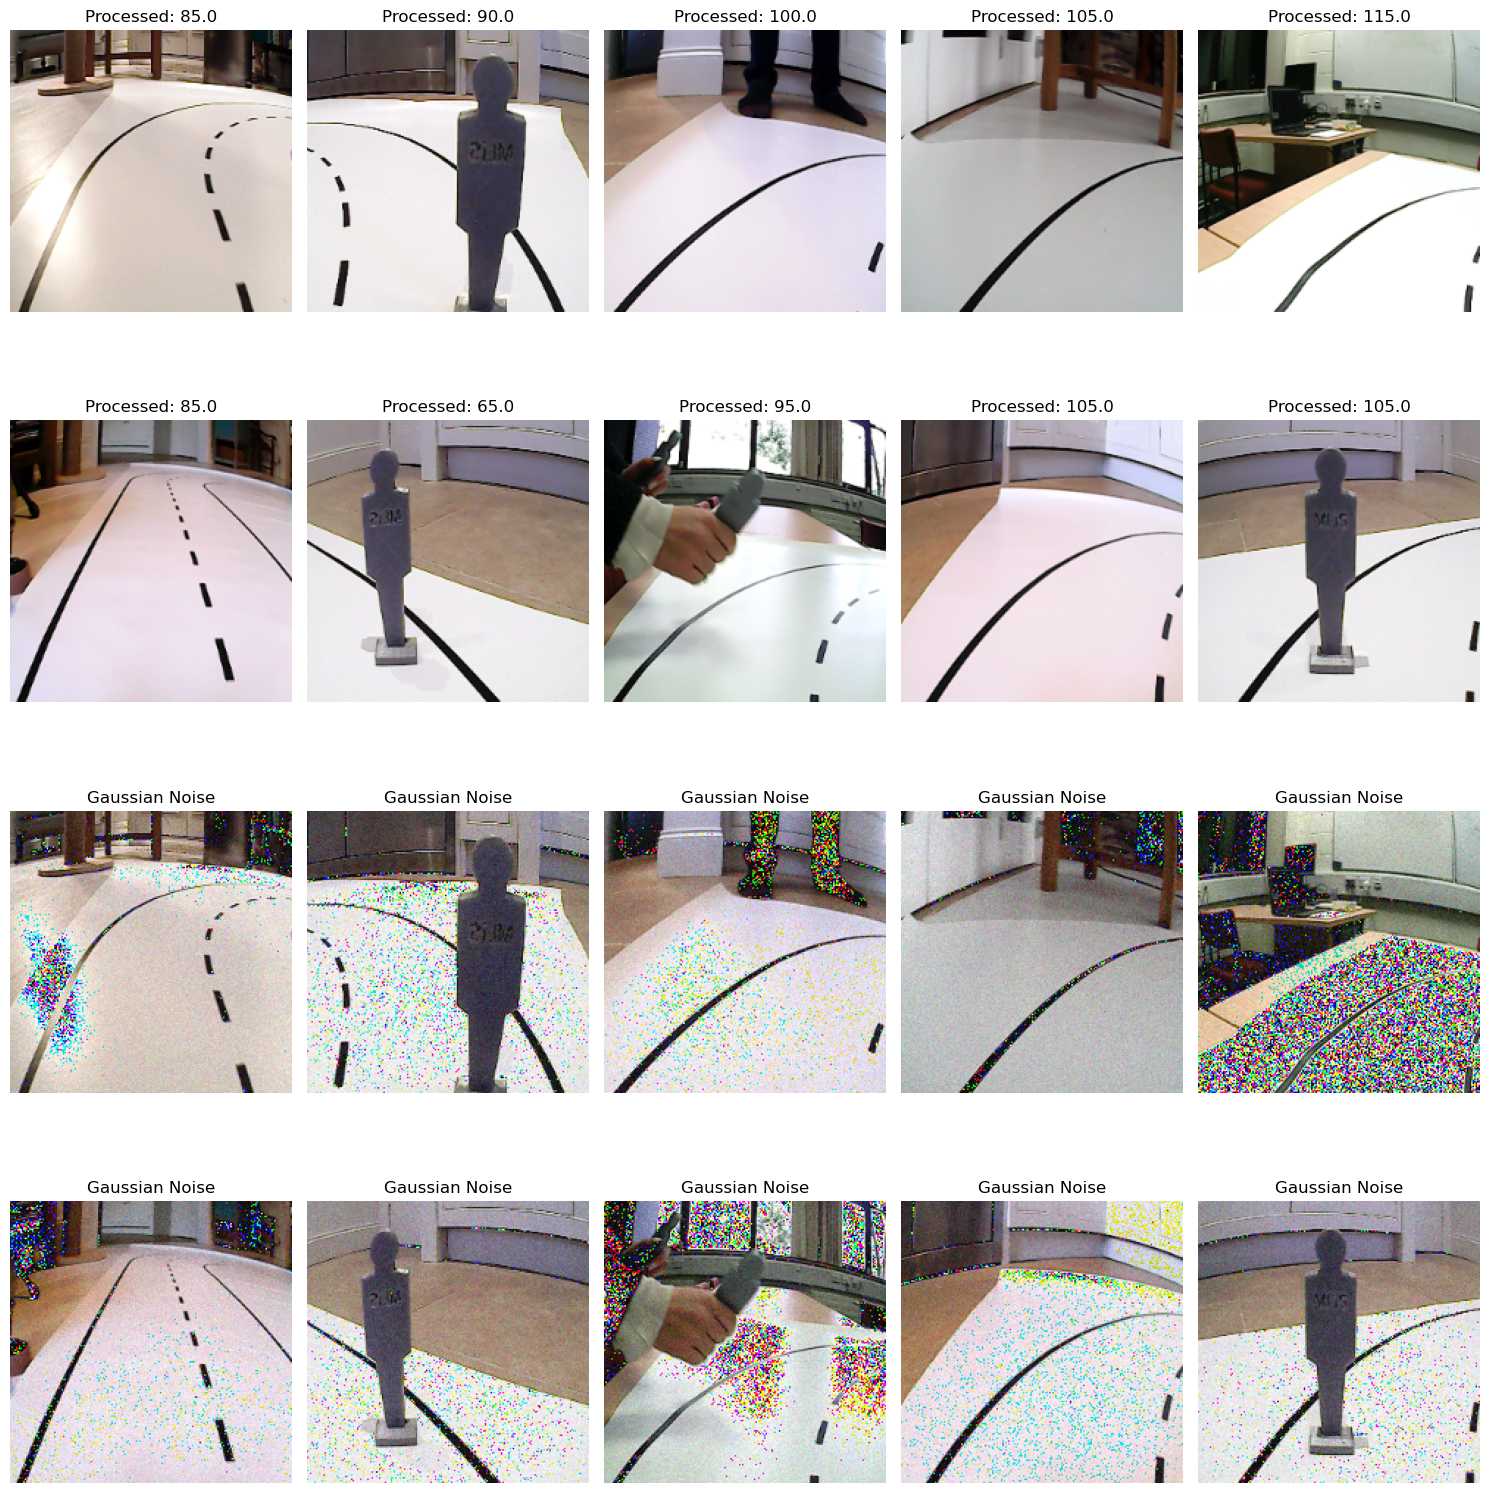

In [183]:
gaussian_noise_layer = tf.keras.layers.GaussianNoise(10)

processed_images_tensor = tf.stack(processed_images)
noisy_images = gaussian_noise_layer(processed_images_tensor, training=True)

# Plotting the original, processed, and blurred images
plt.figure(figsize=(15, 20))
for i in range(min(10, len(images))):  # Adjust range if necessary
    # Plot processed image
    ax = plt.subplot(5, 5, i + 1)  # Offset by 5 to go to the next row
    plt.imshow(processed_images[i].numpy().astype("uint8"))
    plt.title(f"Processed: {p_labels[i]}")
    plt.axis("off")

    # Plot Gaussian blurred image
    ax = plt.subplot(5, 5, i + 11)  # Offset by another 5 to go to the next row
    plt.imshow(noisy_images[i].numpy().astype("uint8"))
    plt.title(f"Gaussian Noise")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Pipeline
### 1. Loading
### 2. Preprocessing (Submission files)
### 3. Augmentation
### 4. Results + Confusion Matrix

##

In [ ]:
import tensorflow_addons as tfa
!pip install --quiet vit-keras

from vit_keras import vit